# Lidando com dados ausentes
#### (Capítulo 2: Encontrando Dados e Usando Data Wrangling com Séries Temporais)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from rich import print
from scipy.interpolate import interp1d
from statsmodels.tsa.api import SimpleExpSmoothing

import catppuccin
mpl.style.use(catppuccin.PALETTE.mocha.identifier)

# Lendo os dados
unemp = pd.read_csv("data/UNRATE.csv")
unemp['DATE'] = pd.to_datetime(unemp['DATE'])
unemp

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
839,2017-12-01,4.1
840,2018-01-01,4.1
841,2018-02-01,4.1
842,2018-03-01,4.1


In [2]:
# Gerando um conjunto de dados com valores ausentes aleatórios
rand_unemp_idx = np.random.choice(unemp.index, int(0.1 * len(unemp)), replace=False)

# Substituir os valores da coluna 'UNRATE' nos índices escolhidos por NaN
rand_unemp = unemp.copy()
rand_unemp.loc[rand_unemp_idx, 'UNRATE'] = np.nan

In [3]:
# Identificar os índices onde o valor da taxa de desemprego é maior que 8
high_unemp_idx = unemp[unemp['UNRATE'] > 8].index

# Escolher aleatoriamente 50% desses índices
indices_to_na = np.random.choice(high_unemp_idx, int(0.5 * len(high_unemp_idx)), replace=False)

# Substituir os valores da coluna 'UNRATE' nos índices escolhidos por NaN
bias_unemp = unemp.copy()
bias_unemp.loc[indices_to_na, 'UNRATE'] = np.nan

In [4]:
# Marcando valores ausentes
rand_unemp['rpt'] = rand_unemp['UNRATE'].isna()
bias_unemp['rpt'] = bias_unemp['UNRATE'].isna()

In [5]:
print(f'"bias_unemp"\n{bias_unemp.isna().value_counts()}')
print(f'\n"rand_unemp"\n{rand_unemp.isna().value_counts()}')

"bias_unemp"
DATE   UNRATE  rpt  
False  False   False    804
       True    False     40
Name: count, dtype: int64

"rand_unemp"
DATE   UNRATE  rpt  
False  False   False    760
       True    False     84
Name: count, dtype: int64

<div style="background-color:#171723; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif;">
  <h1 style="color:#B7A7E7;">Preenchimento com Forward Fill</h1>

  <p style="color:#FFFFFF;">O <strong style="color:#8aadf4;">forward fill</strong> é uma técnica utilizada para preencher valores ausentes (<code>NaN</code>) em uma série temporal ou em um conjunto de dados. Este método utiliza o valor mais recente disponível antes do valor ausente para preencher os espaços vazios.</p>

  <h2 style="color:#EBCB8B;">Explicação</h2>
  <p style="color:#FFFFFF;">O forward fill é ideal para situações onde o valor anterior é uma boa estimativa para os valores subsequentes. No entanto, se o primeiro valor na série estiver ausente, ele não será preenchido, pois não há valor anterior disponível.</p>
</div>


In [ ]:
# Preenchendo valores ausentes com o método forward fill
rand_unemp['impute_ff'] = rand_unemp['UNRATE'].fillna(method='ffill')
bias_unemp['impute_ff'] = bias_unemp['UNRATE'].fillna(method='ffill')

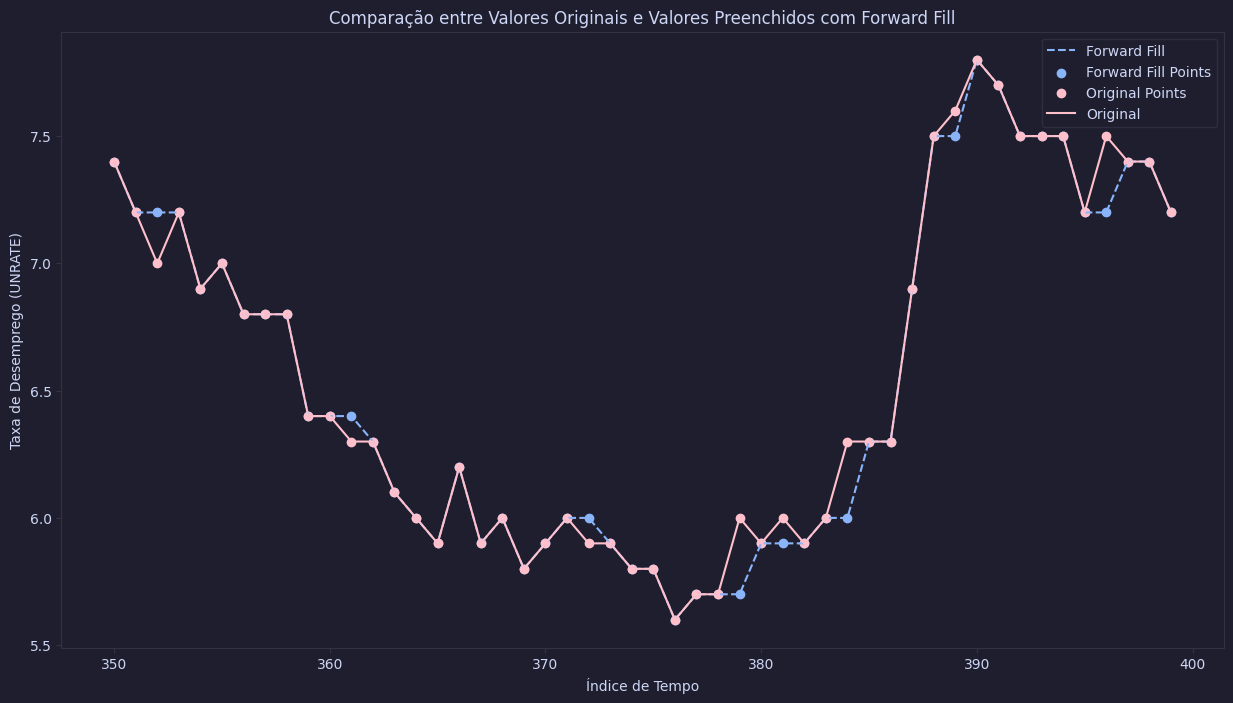

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plotando a série com forward fill
plt.plot(rand_unemp.index[350:400], rand_unemp['impute_ff'][350:400], label='Forward Fill', linestyle='--')

# Scatter plot para todos os pontos preenchidos com forward fill
plt.scatter(rand_unemp.index[350:400], rand_unemp['impute_ff'][350:400], label='Forward Fill Points')

# Scatter plot para todos os pontos da série original
plt.scatter(unemp.index[350:400], unemp['UNRATE'][350:400], label='Original Points', color='pink')

# Plotando a série original
plt.plot(unemp.index[350:400], unemp['UNRATE'][350:400], label='Original', color='pink')

# Adicionando títulos e rótulos aos eixos
plt.title('Comparação entre Valores Originais e Valores Preenchidos com Forward Fill')
plt.xlabel('Índice de Tempo')
plt.ylabel('Taxa de Desemprego (UNRATE)')

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()



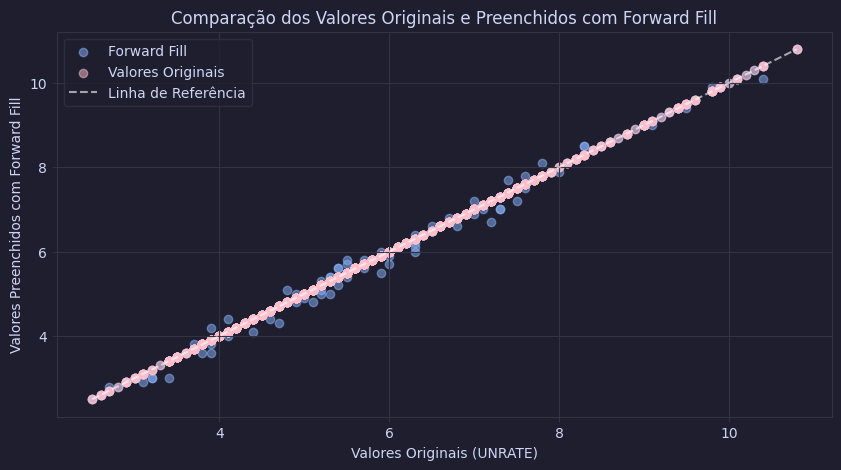

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Scatter plot dos valores originais (eixo x) vs valores aleatórios (eixo y)
plt.scatter(unemp['UNRATE'], rand_unemp['impute_ff'], alpha=0.5, label='Forward Fill')

# Scatter plot dos valores originais (eixo x) vs mesmos valores originais no eixo y
plt.scatter(unemp['UNRATE'], unemp['UNRATE'], color='pink', alpha=0.5, label='Valores Originais')

# Adicionando títulos e rótulos aos eixos
plt.title('Comparação dos Valores Originais e Preenchidos com Forward Fill')
plt.xlabel('Valores Originais (UNRATE)')
plt.ylabel('Valores Preenchidos com Forward Fill')

# Adicionando uma linha de referência para melhor visualização
plt.plot([unemp['UNRATE'].min(), unemp['UNRATE'].max()],
         [unemp['UNRATE'].min(), unemp['UNRATE'].max()],
         linestyle='--', color='white', alpha=0.6, label='Linha de Referência')

plt.legend()
plt.grid(True)
plt.show()



<div style="background-color:#171723; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif;">
  <h1 style="color:#B7A7E7;">Preenchimento de Valores Ausentes com Médias Móveis</h1>
  <p>Este código mostra duas técnicas de preenchimento de valores ausentes usando médias móveis, uma sem previsão (<code>nolookahead</code>) e outra com previsão (<code>lookahead</code>). Vamos entender cada parte:</p>
  <h2 style="color:#A3BE8C;">1. Preenchimento com Média Móvel Sem Previsão</h2>
  <p><strong>Objetivo</strong>: Preencher valores ausentes (<code>NaN</code>) usando a média dos valores ao redor (média móvel) da série temporal.</p>
  <p><strong>Método</strong>:</p>
  <ul style="color:#88C0D0;">
    <li><code>rolling(window=3, min_periods=1, center=True)</code>: Cria uma janela deslizante de tamanho 3. <code>min_periods=1</code> garante que mesmo que a janela não tenha 3 períodos, a média é calculada com os valores disponíveis.</li>
    <li><code>.mean()</code>: Calcula a média dos valores na janela deslizante. Para cada valor, a média é baseada nos valores dentro da janela ao redor do ponto atual. Usa os valores anteriores.</li>
  </ul>
  <p><strong>Explicação</strong>: Neste método, os valores ausentes são preenchidos com a média móvel calculada sem usar qualquer informação futura. Isso significa que a média é calculada apenas com base nos valores passados e presentes em torno do ponto.</p>
  <h2 style="color:#A3BE8C;">2. Preenchimento com Média Móvel Com Previsão</h2>
  <p><strong>Objetivo</strong>: Preencher valores ausentes usando a média móvel calculada com a inclusão de valores futuros.</p>
  <p><strong>Método</strong>:</p>
  <ul style="color:#88C0D0;">
    <li><code>shift(-1)</code>: Desloca a série temporal para frente por 2 períodos. Isso faz com que os valores futuros se tornem disponíveis no cálculo da média.</li>
    <li><code>rolling(window=3, min_periods=1)</code>: Cria uma janela deslizante de tamanho 3, como no método anterior, mas agora a janela inclui valores futuros devido ao deslocamento.</li>
    <li><code>.mean()</code>: Calcula a média dos valores na janela deslizante que agora inclui os valores futuros.</li>
  </ul>
  <p><strong>Explicação</strong>: Neste método, ao deslocar a série para frente com <code>shift(-1)</code>, permite-se que o cálculo da média inclua valores futuros. É importante notar que esse método pode não ser ideal se o objetivo for prever valores futuros com base apenas em informações passadas.</p>
    <h2 style="color:#EBCB8B;">Resumo</h2>
    <li><code>impute_rm_nolookahead</code>: Preenche os valores ausentes usando a média dos valores ao redor sem considerar valores futuros.</li>
    <li><code>impute_rm_lookahead</code>: Preenche os valores ausentes usando a média dos valores ao redor incluindo valores futuros, após deslocar a série.</li>
  </ul>
</div>

In [25]:
# Preenchendo valores ausentes com média móvel sem previsão
rand_unemp['impute_rm_nolookahead'] = rand_unemp['UNRATE'].rolling(window=3, min_periods=1, center=False).mean()
bias_unemp['impute_rm_nolookahead'] = bias_unemp['UNRATE'].rolling(window=3, min_periods=1, center=False).mean()

# Preenchendo valores ausentes com média móvel com previsão
rand_unemp['impute_rm_lookahead'] = rand_unemp['UNRATE'].shift(-1).rolling(window=3, min_periods=1, center=True).mean()
bias_unemp['impute_rm_lookahead'] = bias_unemp['UNRATE'].shift(-1).rolling(window=3, min_periods=1, center=True).mean()


In [26]:
rand_unemp[:23]

,DATE,UNRATE,rpt,impute_ff,impute_rm_nolookahead,impute_rm_lookahead
0,1948-01-01,NaN,True,NaN,NaN,4.000000
1,1948-02-01,NaN,True,NaN,NaN,3.950000
2,1948-03-01,4.0,False,4.0,4.000000,3.800000
3,1948-04-01,3.9,False,3.9,3.950000,3.666667
4,1948-05-01,3.5,False,3.5,3.800000,3.566667
5,1948-06-01,3.6,False,3.6,3.666667,3.600000
6,1948-07-01,3.6,False,3.6,3.566667,3.700000
7,1948-08-01,NaN,True,3.6,3.600000,3.800000
8,1948-09-01,3.8,False,3.8,3.700000,3.800000
9,1948-10-01,NaN,True,3.8,3.800000,3.900000


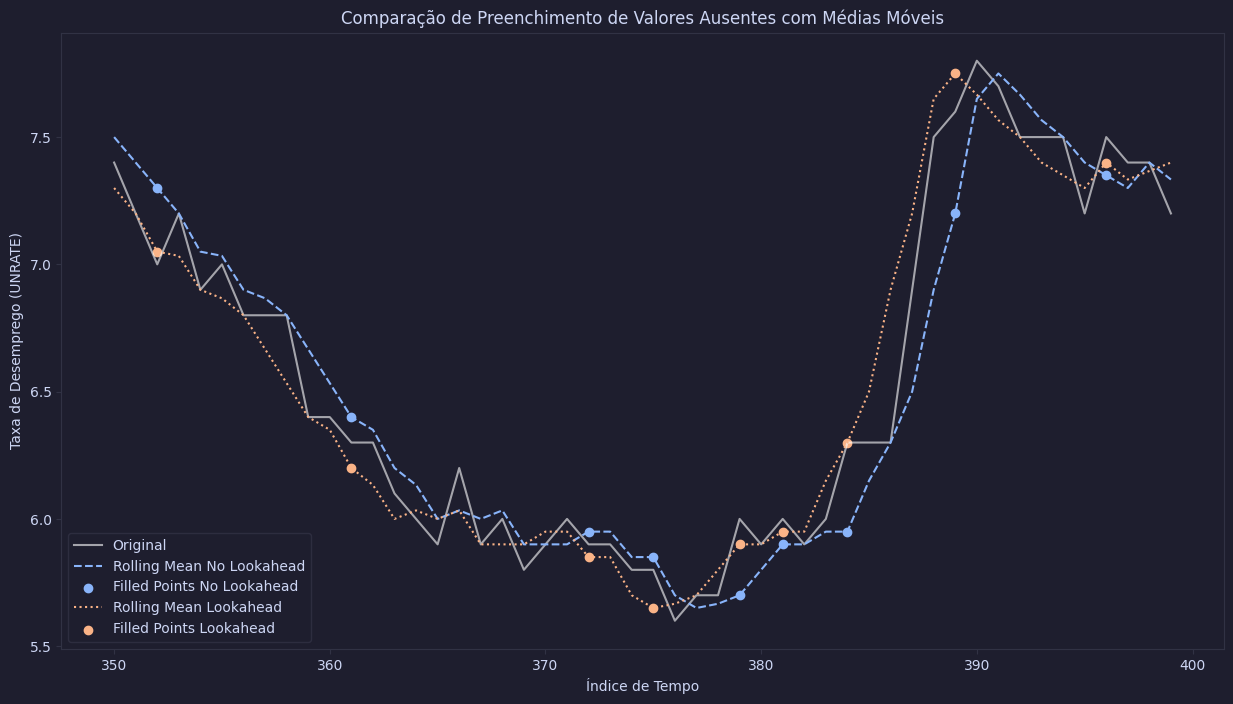

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Definindo o intervalo de uso
use_idx = slice(350, 400)

# Plotando a série original
plt.plot(unemp.index[use_idx], unemp['UNRATE'][use_idx], label='Original', color='white', alpha=0.6)

# Plotando a média móvel sem previsão
plt.plot(rand_unemp.index[use_idx], rand_unemp['impute_rm_nolookahead'][use_idx], label='Rolling Mean No Lookahead', linestyle='--')

# Scatter plot para os pontos preenchidos com a média móvel sem previsão
plt.scatter(rand_unemp.index[use_idx][rand_unemp['rpt'][use_idx]], rand_unemp['impute_rm_nolookahead'][use_idx][rand_unemp['rpt'][use_idx]], label='Filled Points No Lookahead')

# Plotando a média móvel com previsão
plt.plot(rand_unemp.index[use_idx], rand_unemp['impute_rm_lookahead'][use_idx], label='Rolling Mean Lookahead', linestyle=':')

# Scatter plot para os pontos preenchidos com a média móvel com previsão
plt.scatter(rand_unemp.index[use_idx][rand_unemp['rpt'][use_idx]], rand_unemp['impute_rm_lookahead'][use_idx][rand_unemp['rpt'][use_idx]], label='Filled Points Lookahead')

# Adicionando título e rótulos aos eixos
plt.title('Comparação de Preenchimento de Valores Ausentes com Médias Móveis')
plt.xlabel('Índice de Tempo')
plt.ylabel('Taxa de Desemprego (UNRATE)')

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()



<div style="background-color:#171723; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif;">
  <h1 style="color:#B7A7E7;">Interpolação</h1>
  
  <p style="color:#FFFFFF;">A <strong style="color:#8aadf4;">interpolação linear</strong> preenche os valores ausentes com base em uma linha reta entre os pontos conhecidos mais próximos.</p>
  
  <p style="color:#FFFFFF;">A <strong style="color:#8bd5ca;">interpolação polinomial</strong> preenche os valores ausentes ajustando um polinômio aos pontos conhecidos mais próximos.</p>
  
  <p style="color:#FFFFFF;">O parâmetro <code style="color:#f5a97f;">order=2</code> indica o uso de um polinômio de segunda ordem (quadrático) para fazer a interpolação.</p>

</div>

In [35]:
# Preenchendo valores ausentes com interpolação linear
rand_unemp['impute_li'] = rand_unemp['UNRATE'].interpolate(method='linear')
bias_unemp['impute_li'] = bias_unemp['UNRATE'].interpolate(method='linear')

# Preenchendo valores ausentes com interpolação polinomial
rand_unemp['impute_sp'] = rand_unemp['UNRATE'].interpolate(method='polynomial', order=2)
bias_unemp['impute_sp'] = bias_unemp['UNRATE'].interpolate(method='polynomial', order=2)


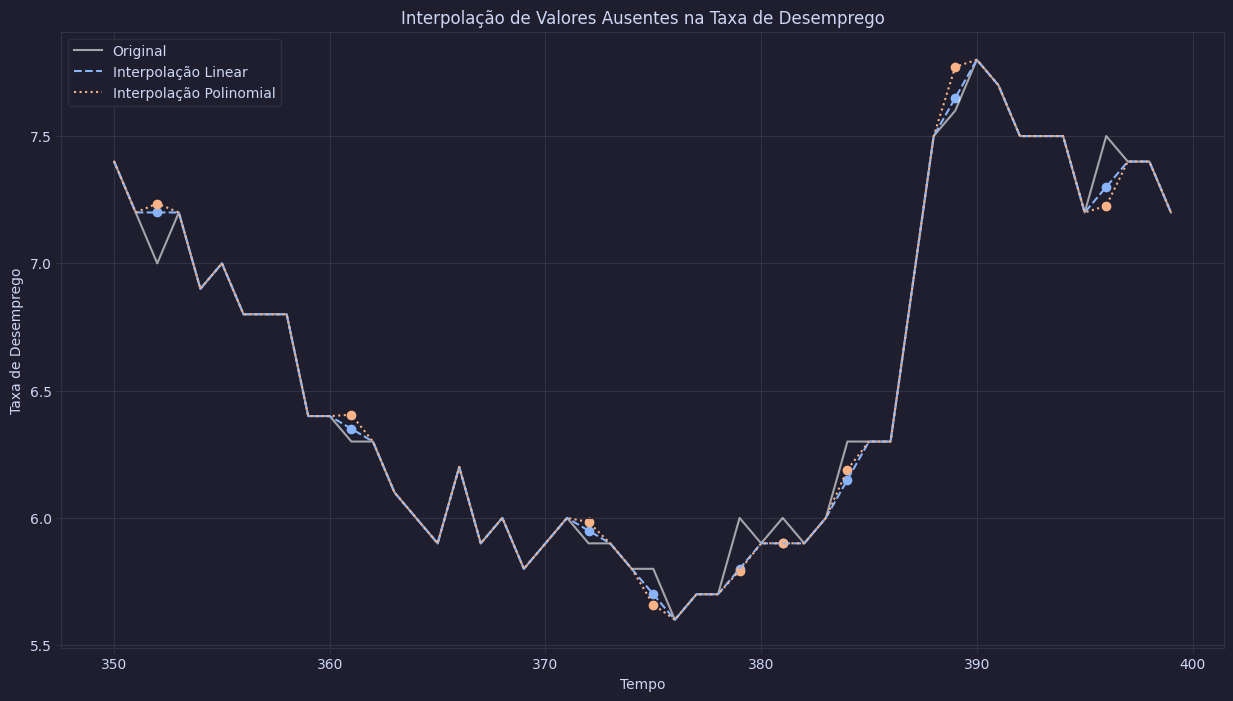

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Definindo o intervalo de uso
use_idx = slice(350, 400)

# Plotando a série original
plt.plot(unemp.index[use_idx], unemp['UNRATE'][use_idx], label='Original', color='white', alpha=0.6)

# Plotando a interpolação linear
plt.plot(rand_unemp.index[use_idx], rand_unemp['impute_li'][use_idx], label='Interpolação Linear', linestyle='--')
plt.scatter(rand_unemp.index[use_idx][rand_unemp['rpt'][use_idx]], rand_unemp['impute_li'][use_idx][rand_unemp['rpt'][use_idx]])

# Plotando a interpolação polinomial
plt.plot(rand_unemp.index[use_idx], rand_unemp['impute_sp'][use_idx], label='Interpolação Polinomial', linestyle=':')
plt.scatter(rand_unemp.index[use_idx][rand_unemp['rpt'][use_idx]], rand_unemp['impute_sp'][use_idx][rand_unemp['rpt'][use_idx]])

# Adicionando título e legendas
plt.title('Interpolação de Valores Ausentes na Taxa de Desemprego')
plt.xlabel('Tempo')
plt.ylabel('Taxa de Desemprego')
plt.legend()
plt.grid(True)

# Mostrando o gráfico
plt.show()


In [45]:
# Filtrando apenas colunas numéricas para evitar o erro
numeric_cols = ['impute_ff', 'impute_rm_nolookahead', 'impute_rm_lookahead', 'impute_li', 'impute_sp']

# Comparando o erro quadrático médio dos métodos de imputação
errors_rand_unemp = rand_unemp[numeric_cols].apply(lambda x: np.mean((x - unemp['UNRATE'])**2), axis=0)
errors_bias_unemp = bias_unemp[numeric_cols].apply(lambda x: np.mean((x - unemp['UNRATE'])**2), axis=0)

print("Erro quadrático médio (Rand Unemp):")
print(errors_rand_unemp[['impute_ff', 'impute_rm_nolookahead', 'impute_rm_lookahead', 'impute_li', 'impute_sp']].sort_values())

print("Erro quadrático médio (Bias Unemp):")
print(errors_bias_unemp[['impute_ff', 'impute_rm_nolookahead', 'impute_rm_lookahead', 'impute_li', 'impute_sp']].sort_values())

# Suavização exponencial simples
model = SimpleExpSmoothing(unemp['UNRATE']).fit(smoothing_level=0.1, optimized=False)
unemp['smoothed'] = model.fittedvalues

plt.figure()
plt.plot(unemp['UNRATE'], label='Original', linestyle='--')
plt.plot(unemp['smoothed'], label='Smoothed', linestyle='-')
plt.legend()
plt.savefig("smoothed.png")
plt.close()


Erro quadrático médio (Rand Unemp):

impute_li                0.001568
impute_sp                0.002228
impute_ff                0.003658
impute_rm_nolookahead    0.027647
impute_rm_lookahead      0.028431
dtype: float64

Erro quadrático médio (Bias Unemp):

impute_sp                0.000984
impute_li                0.002198
impute_ff                0.006908
impute_rm_lookahead      0.026730
impute_rm_nolookahead    0.029560
dtype: float64